## Conditional DDPM/DDIM with Sobel Filter
### [MNIST Code]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from model.resunetv2 import ResUNetv2
import torch.nn.functional as F
import cv2
from pytorch_model_summary import summary
import math
import os

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


make directories

In [2]:
if not os.path.exists(f"content"):
    os.makedirs(f"content")

if not os.path.exists(f"content/ddpm_sobel"):
    os.makedirs(f"content/ddpm_sobel")

if not os.path.exists(f"content/ddim_sobel"):
    os.makedirs(f"content/ddim_sobel")

if not os.path.exists(f"weight"):
    os.makedirs(f"weight")

Show Function (input: tensor)

In [11]:
def imshow(img):
    '''
    input: tensor [1, h, w]
    '''
    d_img = (img[0] + 1.0) / 2.0
    plt.figure(figsize=(5,5))   
    plt.imshow(d_img, cmap='gray')
    plt.axis('off')
    plt.show()

## Training Process

GPU check

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset Loading

In [49]:
batch_size = 256
rsl = 32 

In [10]:
transform = transforms.Compose([transforms.Resize((rsl, rsl)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: (x*2) -1)])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

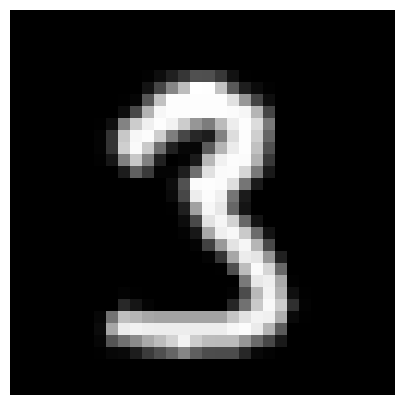

In [17]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]

imshow(image)

In [8]:
print(torch.min(image), torch.max(image))

tensor(-1.) tensor(0.9922)


Make Sobel Images

In [6]:
def sobelFilter(img, device):
    '''
    input: tensor [1, h, w]
    '''
    sobel_filter_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    sobel_filter_x.weight.data = torch.FloatTensor([[[[-1, -2, -1],
                                                    [0, 0, 0],
                                                    [1, 2, 1]]]]).to(device)

    sobel_fiter_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    sobel_fiter_y.weight.data = torch.FloatTensor([[[[-1, 0, 1], 
                                                    [-2, 0, 2],
                                                    [-1, 0, 1]]]]).to(device)
    
    return (sobel_filter_x(img) + sobel_fiter_y(img)).to(device)

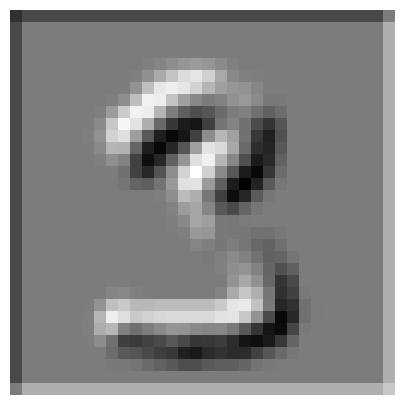

In [18]:
sobel_image = sobelFilter(image.unsqueeze(0).to(device), device)[0].cpu().detach()

imshow(sobel_image)

Define Model

In [12]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [13]:
resolution=32
in_channels=1
std_cnl=64
ted=256
ced=64

In [14]:
model = ResUNetv2(resolution, in_channels, std_cnl, ted, ced).to(device)
model.train()

x = torch.ones([batch_size, in_channels, rsl, rsl]).cuda()
t = torch.ones([batch_size, ted]).cuda()
c = torch.ones([batch_size, in_channels, rsl, rsl]).cuda()

print(summary(model,x,t,c))
print('input:',x.shape,t.shape,c.shape)
print('output:',model(x,t,c).shape)
print('===================================')

model.apply(initialize_weights)

----------------------------------------------------------------------------------------------
      Layer (type)                               Output Shape         Param #     Tr. Param #
          Linear-1                                  [256, 64]          16,448          16,448
          Linear-2                                 [256, 128]          32,896          32,896
          Linear-3                                 [256, 256]          65,792          65,792
          Linear-4                                 [256, 512]         131,584         131,584
          Conv2d-5                          [256, 64, 32, 32]             128             128
      InResBlock-6       [256, 64, 32, 32], [256, 64, 32, 32]          37,696          37,696
    DownResBlock-7     [256, 128, 16, 16], [256, 128, 16, 16]         221,696         221,696
    DownResBlock-8         [256, 256, 8, 8], [256, 256, 8, 8]         885,760         885,760
    ResAttnBlock-9                           [256, 256, 8, 

ResUNetv2(
  (t_fc1): Linear(in_features=256, out_features=64, bias=True)
  (t_fc2): Linear(in_features=256, out_features=128, bias=True)
  (t_fc3): Linear(in_features=256, out_features=256, bias=True)
  (t_fc4): Linear(in_features=256, out_features=512, bias=True)
  (c_embedding): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (resblock_s1): InResBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leaky_relu1): LeakyReLU(negative_slope=0.2)
    (leaky_relu2): LeakyReLU(negative_slope=0.2)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblock_s2): DownResBlock(
    (down_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leaky_relu1): LeakyReLU(negative_slope=0.2)
    (leaky_relu2): LeakyReLU(negative_

Diffusion Model Parameters

In [44]:
def beta_schedule(timesteps=1000, linear=True):
    scale = 1000 / timesteps
    if linear: 
        beta_start = scale * 0.0001
        beta_end = scale * 0.01
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
    # quadratic 
    else:
        beta_start = (scale * 0.0001)**0.5
        beta_end = (scale * 0.01)**0.5
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)**2

beta_list = beta_schedule(timesteps=1000, linear=True)
alpha_list = 1.0 - beta_list
alpha_bar_list = torch.cumprod(alpha_list, dim=0)

sqrt_alpha_bar_list = torch.sqrt(alpha_bar_list)
sqrt_one_minus_alpha_bar_list = torch.sqrt(1.0 - alpha_bar_list)
one_div_sqrt_alpha_list = 1.0 / torch.sqrt(alpha_list)

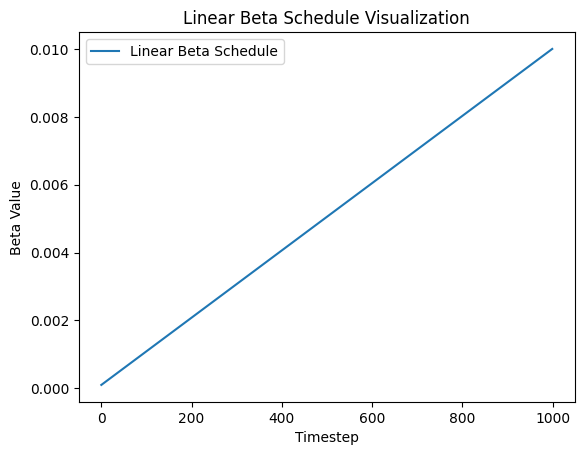

In [45]:
plt.plot(beta_list.numpy(), label='Linear Beta Schedule')
plt.xlabel('Timestep')
plt.ylabel('Beta Value')
plt.title('Linear Beta Schedule Visualization')
plt.legend()
plt.show()

Positional Encoding

In [46]:
def PE(pos_num, d_model, n):
    posses = np.arange(pos_num)

    i = np.arange(d_model)//2
    exponent = 2*i/d_model
    pos_emb = posses[:, np.newaxis] / np.power(n, exponent)

    pos_emb[:, 0::2] = np.sin(pos_emb[:, 0::2])
    pos_emb[:, 1::2] = np.cos(pos_emb[:, 1::2])

    pos_emb = torch.from_numpy(pos_emb).float()

    return pos_emb

Set Time Embedding

In [47]:
timestep_num = 1000
d_model = 256
n = 10000
t_emb_set = PE(pos_num=timestep_num, d_model=d_model, n=n).to(device)

Visualization Embedding

[142 910 931 280 777 590 617 499 847 622 801 235 318  18 544 365 531 224
 344 179 659 327 633  98 195 371 916 515 659 375 457 545 525 689 458 351
 383 814 351 281 268 525 626 623 352 105 222 586 173 785 767 892 544 335
 363 621 921 915 959 789 827 561 712 578 936 390 491 715 242 776 264 958
 622 986 294 568 157 683 567 330  54 756 471 104 351 171 830 666 178 136
 594 420 867 650 954 552 830 585  70 273 412 504 745 896  23 842 288 221
 415  86  96 749 135  49 837 331 239 510 197 814 735 289 567 720 598 337
 446 253 640 235  17  79 427 833 885 222 287 571 145 610 895 500 811  19
 554 524 906 835 478 153  73 404  74 295 968 940  60 666 200 287 797 102
 246 959  77 138 791  41 337 333 451  99 917 718 123 157 134 351 162 765
 884  24 170  46 355 226 677 764 699 389 725 272 359  79 388  64 851 212
 688 118 420 990 943 963 226 152 146 981 361 168 514 803 274 355 246 160
 867 548 884 712 443 708 922 855 146 376 964 360 845 408 891 498 643 564
 941 991 991 986 684  75 138 283 664 736 614 658 92

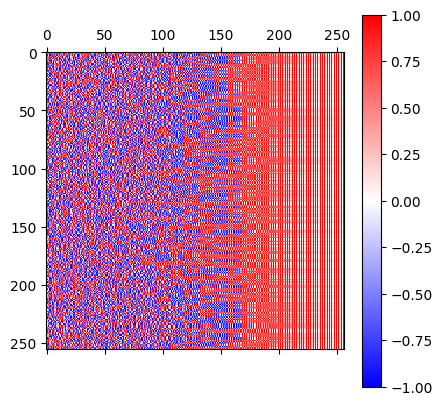

In [50]:
# get time embedding
t_test = np.random.randint(0,timestep_num,size=batch_size)
print(t_test)

t_emb_test = t_emb_set[t_test]
print(t_emb_test.shape)

# visualization
plt.matshow(t_emb_test.cpu(), cmap=plt.get_cmap('bwr'))
plt.colorbar()

Training Setting

In [20]:
learning_rate = 1e-4
epochs = 100

Set loss function and Optimizer

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
sch = torch.optim.lr_scheduler.PolynomialLR(optimizer=optimizer, total_iters=epochs)

Training

In [22]:
SAVE_PATH = './weight/sobel_ddpm_mnist'
BEST_SAVE_PATH = './weight/sobel_ddpm_mnist_best.pth'
LAST_SAVE_PATH = './weight/sobel_ddpm_mnist_last.pth'
losses = []
val_losses = [] 

In [23]:
print('-------------------------------------------------------------------')
print("Training Start")
print('-------------------------------------------------------------------\n')

epoch = 0 

for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0

    for iter, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        data_size = len(inputs)

        # get time embedding
        t = torch.randint(0, timestep_num, size=(data_size,), device=inputs.device).long()
        emb_t = t_emb_set[t].to(device)

        # get condition 
        c = sobelFilter(inputs, device).to(device)

        # forward process
        esp = torch.randn_like(inputs).to(device)
        noise_img = torch.zeros((data_size, 1, rsl, rsl), dtype=torch.float32).to(device)
        for i in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[i]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[i]]
            noise_img[i] = alpha_bar * inputs[i] + one_minus_alpha_bar * esp[i]

        # reverse process
        optimizer.zero_grad()
        output = model(noise_img, emb_t, c)
        loss = criterion(output, esp)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # check loss per 50 iteration
        if (iter+1) % 50 == 0:
            print(f"[{iter+1}] Loss: {loss.item()}")

    # scheduler update
    sch.step()
    
    # record training loss
    losses.append(running_loss / len(train_loader))
    print('-------------------------------------------------------------------')
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    # save model per 10 epoch
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), SAVE_PATH+f'_{epoch+1}epoch.pth')
        print('<< model save at [%d] epoch! >>' % (epoch+1))

    '''
    -------------------------
    validation per one epoch
    -------------------------
    '''
    model.eval()
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        data_size = len(inputs)

        # get time embedding
        t = torch.randint(0, timestep_num, size=(data_size,), device=inputs.device).long()
        emb_t = t_emb_set[t].to(device)

        # get condition 
        c = sobelFilter(inputs,device)

        # forward process
        esp = torch.randn_like(inputs).to(device)
        noise_img = torch.zeros((data_size, 1, rsl, rsl), dtype=torch.float32).to(device)
        for j in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[j]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[j]]
            noise_img[j] = alpha_bar * inputs[j] + one_minus_alpha_bar * esp[j]

        # reverse process
        output = model(noise_img, emb_t, c)
        loss = criterion(output, esp)
        val_running_loss += loss.item()

    # calculate avg val loss
    val_loss = val_running_loss / len(test_loader)

    # early stopping
    if (epoch+1) > 1: 
        if val_loss < min(val_losses):
            best_epoch = epoch
            best_loss = np.round(val_loss,4)
            torch.save(model.state_dict(), BEST_SAVE_PATH)
            print('<<< Best model save at [%d] epoch! >>>' % (epoch+1))

    # record validation loss
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {val_loss}")
    print('-------------------------------------------------------------------\n')
    model.train()

# last epoch -> save last model 
print("Training End")
torch.save(model.state_dict(), LAST_SAVE_PATH)
print("Last Model Saved")

-------------------------------------------------------------------
Training Start
-------------------------------------------------------------------

[50] Loss: 0.42900580167770386
[100] Loss: 0.31115853786468506
[150] Loss: 0.2515597343444824
[200] Loss: 0.22045469284057617
-------------------------------------------------------------------
Epoch 1/100, Loss: 0.39414307931636244
Epoch 1/100, Valid Loss: 0.19802548550069332
-------------------------------------------------------------------

[50] Loss: 0.1760379821062088
[100] Loss: 0.16572794318199158
[150] Loss: 0.14962545037269592
[200] Loss: 0.13160499930381775
-------------------------------------------------------------------
Epoch 2/100, Loss: 0.15263309259998037
<<< Best model save at [2] epoch! >>>
Epoch 2/100, Valid Loss: 0.12068566009402275
-------------------------------------------------------------------

[50] Loss: 0.1217225193977356
[100] Loss: 0.11337076872587204
[150] Loss: 0.09758278727531433
[200] Loss: 0.08198438

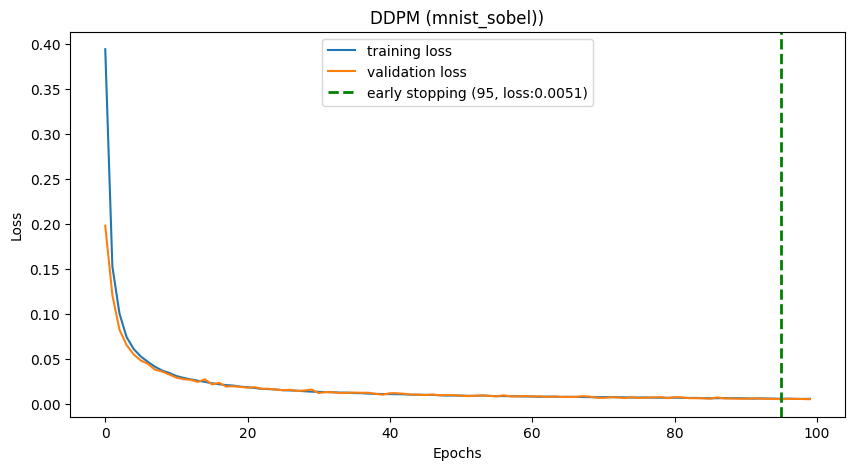

In [24]:
plt.figure(figsize=(10,5))
plt.title("DDPM (mnist_sobel))")
plt.plot(losses,label="training loss")
plt.plot(val_losses,label="validation loss")
plt.axvline(best_epoch, color='green', linestyle='--', linewidth=2, label=f"early stopping ({best_epoch}, loss:{best_loss})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generating Process

model

In [53]:
resolution=32
in_channels=1
std_cnl=64
ted=256
ced=64

SAVED_PATH = './weight/sobel_ddpm_mnist_best.pth'

In [54]:
model = ResUNetv2(resolution, in_channels, std_cnl, ted, ced).to(device)

try:
    model.load_state_dict(torch.load(SAVED_PATH))
    model.eval()
    print('load model ok!')
except:
    print('error')

load model ok!


condition (randomly)

In [55]:
width_num = 10
height_num = 10
total_num = width_num * height_num
condition = torch.zeros(total_num, 32, 32, 1).to(device)

In [76]:
test_dataiter = iter(test_loader)
test_images, test_labels = next(test_dataiter)
sobel_outputs = sobelFilter(test_images.to(device), device)

t = torch.randint(0, batch_size, size=(1,), device=device).long()
condition = sobel_outputs[t : t+total_num] # [100, 32, 32, 1]

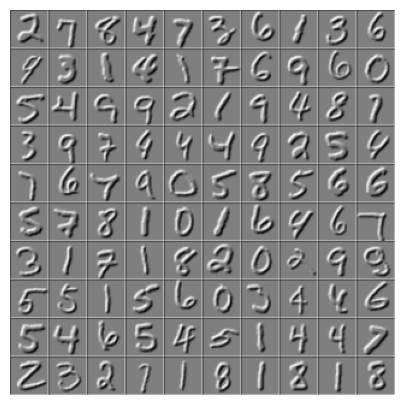

save ok!


In [77]:
np_cond = condition.permute(0,2,3,1).cpu().detach().numpy()
out_img = np.zeros((32*height_num,32*width_num,3)) # [320, 320, 3]

# reshape numpy images
rs_img = np.resize(np_cond, (height_num, width_num, rsl, rsl)) # [10, 10, 32, 32]

# make numpy images to grid image
for i in range(height_num):
    for j in range(width_num):
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :]
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :]
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :]

# show
show = torch.from_numpy(out_img).permute(2,0,1)[0].unsqueeze(0) # [1, 320, 320]
imshow(show)

# save
norm = (out_img - np.min(out_img)) / (np.max(out_img)-np.min(out_img))*255
file_path = f"./content/mnist_sobel.png"
cv2.imwrite(file_path, norm)
print('save ok!')

image setting

In [58]:
batch_size = total_num
rsl = 32
width = rsl * 10
height = rsl * 10
channel = 1
ted = 256

make video (ddpm inversion)

In [80]:
with torch.no_grad():
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('./content/ddpm_sobel/ddpm_mnist_sobel.avi', fourcc, 20, (height, width))
    out_img = np.zeros((height,width,3)) # [320, 320, 3]

    # get first image (noise)
    g_img = torch.randn((batch_size, 1, rsl, rsl), dtype=torch.float32).to(device) # [100, 1, 32, 32]
    
    # Inference 
    for t in range(timestep_num - 1, -1, -1): # 999 ~ 0 => 1000 step to 1 step 
        # time step, condition 
        emb_t = t_emb_set[t].view(-1, ted)
        emb_t = emb_t.expand(batch_size, ted).to(device) # [100, 256]
        c = condition # [100, 1, 32, 32]

        # forward 
        pred_noise = model(g_img, emb_t, c)

        # get t-th images 
        z = torch.randn((batch_size, 1, rsl, rsl), dtype=torch.float32).to(device) # [100, 1, 32, 32]
        mu = one_div_sqrt_alpha_list[t] * (g_img - (beta_list[t] / sqrt_one_minus_alpha_bar_list[t]) * pred_noise)
        g_img = mu + (torch.sqrt(beta_list[t])*z)
        # g_img = mu + (beta_list[t]*z)  # If use variance instead of std, you can get better fidelity but lower diversity! 
        g_img = torch.clip(g_img, -1.0, 1.0)

        # make numpy images
        g_np = torch.zeros_like(g_img) # [100, 1, 32, 32]
        g_np[:,0] = ((g_img[:,0] + 1.0) / 2.0) * 255. # mnist is only one channel (from -1~1 to 0~255)
        g_np = g_np.permute(0,2,3,1).cpu().detach().numpy() # [100, 32, 32, 1]
        
        # reshape numpy images
        rs_img = np.resize(g_np, (height_num, width_num, rsl, rsl)) # [10, 10, 32, 32]

        # make numpy images to grid image
        for i in range(height_num):
            for j in range(width_num):
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :]

        # make video 
        out_img = np.uint8(out_img)
        out.write(out_img)

        # save grid image per 100 time step 
        if ((t+1) < 1000) and ((t+1) % 100 == 0):
            print(f'{t+1} step')
            file_path = f"./content/ddpm_sobel/{t+1}_step_img.png"
            cv2.imwrite(file_path, out_img)

    # finish
    file_path = f"./content/ddpm_sobel/last_img.png"
    cv2.imwrite(file_path, out_img)
    out.release()
    print('save video_ddpm_sobel ok!')

900 step
800 step
700 step
600 step
500 step
400 step
300 step
200 step
100 step
save video_ddpm_sobel ok!


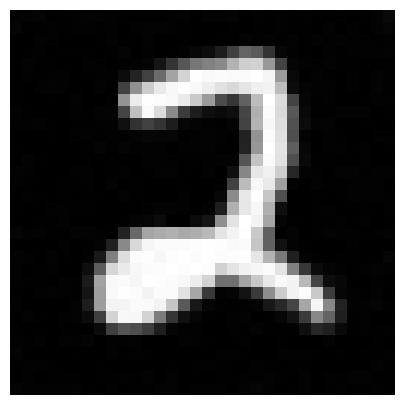

In [81]:
imshow(g_img[0].cpu())

make video (ddim inversion)

- eta = 0 -> ddim mode (low FID = high fidelity, diversity)
- eta = 1 -> ddpm mode (high FID = low fidelity, diversity)

In [66]:
total_timesteps  = 1000
sampling_timesteps = 100 # 10 times faster

In [67]:
def objective(ddim=True):
    if ddim:
        return 0
    else:
        return 1
    
eta = objective(True)
print('eta:',eta)

eta: 0


In [78]:
with torch.no_grad():
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('./content/ddim_sobel/ddim_mnist_sobel.avi', fourcc, 20, (width, height))
    out_img = np.zeros((height,width,3)) # [320, 320, 3]

    # get first image (noise)
    g_img = torch.randn((batch_size, 1, rsl, rsl), dtype=torch.float32).to(device) # [100, 1, 32, 32]

    # get time_pairs 
    times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]
    
    # Inference
    for time, time_next in time_pairs:
        emb_t = t_emb_set[time].view(-1, ted) # [100, 256]
        c = condition # [100, 1, 32, 32]

        # model forward 
        pred_noise = model(g_img, emb_t, c)

        # set alpha
        alpha = alpha_bar_list[time]
        alpha_next = alpha_bar_list[time_next]
        sqrt_alpha = torch.sqrt(alpha)
        sqrt_alpha_next = torch.sqrt(alpha_next)
    
        # predict x0
        numerator = g_img - (torch.sqrt(1-alpha) * pred_noise)
        pred_x0 = numerator / sqrt_alpha

        if time_next < 0:
            g_img = pred_x0
            continue
        
        # predict direction_pointing 
        sigma = eta * torch.sqrt((1 - alpha_next) / (1 - alpha) * (1 - alpha / alpha_next))
        variance = sigma ** 2 
        direction_pointing = torch.sqrt(1-alpha_next-variance) * pred_noise

        # generate next image 
        g_img = (sqrt_alpha_next * pred_x0) + direction_pointing
        g_img = torch.clip(g_img, -1.0, 1.0)

        # make numpy images
        g_np = torch.zeros_like(g_img) # [100, 1, 32, 32]
        g_np[:,0] = ((g_img[:,0] + 1.0) / 2.0) * 255. # mnist is only one channel (from -1~1 to 0~255)
        g_np = g_np.permute(0,2,3,1).cpu().detach().numpy() # [100, 32, 32, 1]
    
        # reshape numpy images
        rs_img = np.resize(g_np, (height_num, width_num, rsl, rsl)) # [10, 10, 32, 32]

        # make numpy images to grid image
        for i in range(height_num):
            for j in range(width_num):
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :]

        # make video 
        out_img = np.uint8(out_img)
        out.write(out_img)

        # save grid image per sampling time step 
        print(f'{time+1} step')
        file_path = f"./content/ddim_sobel/{time+1}_step_img.png"
        cv2.imwrite(file_path, out_img)

    # finish
    file_path = f"./content/ddim_sobel/last_img.png"
    cv2.imwrite(file_path, out_img)
    out.release()
    print('save video_ddim_sobel ok!')

1000 step
990 step
980 step
970 step
960 step
950 step
940 step
930 step
920 step
910 step
900 step
890 step
880 step
870 step
860 step
850 step
840 step
830 step
820 step
810 step
800 step
790 step
780 step
770 step
760 step
750 step
740 step
730 step
720 step
710 step
700 step
690 step
680 step
670 step
660 step
650 step
640 step
630 step
620 step
610 step
600 step
590 step
580 step
570 step
560 step
550 step
540 step
530 step
520 step
510 step
500 step
490 step
480 step
470 step
460 step
450 step
440 step
430 step
420 step
410 step
400 step
390 step
380 step
370 step
360 step
350 step
340 step
330 step
320 step
310 step
300 step
290 step
280 step
270 step
260 step
250 step
240 step
230 step
220 step
210 step
200 step
190 step
180 step
170 step
160 step
150 step
140 step
130 step
120 step
110 step
100 step
90 step
80 step
70 step
60 step
50 step
40 step
30 step
20 step
save video_ddim_sobel ok!


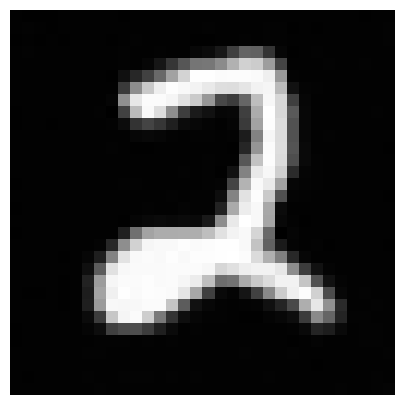

In [79]:
imshow(g_img[0].cpu())